In [89]:
%matplotlib inline
import matplotlib.pylab as plt

# Gutenberg N-Grams

Start the Spark Context: 

In [2]:
import sys, os
os.environ['SPARK_DRIVER_MEMORY'] = '8g'

import pyspark
from pyspark import SparkConf, SparkContext

In [3]:
conf = SparkConf()

In [4]:
num_execs = 10
exec_cores = 4

In [5]:
conf.set('spark.executor.memory', '8g')
conf.set('spark.executor.instances', str(num_execs))
conf.set('spark.executor.cores', str(exec_cores))
conf.set('spark.executorEnv.PYTHONPATH', 
         '/cluster/apps/spark/spark-1.4.0-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip:/cluster/apps/spark/spark-1.4.0-bin-hadoop2.6/python/:/cluster/home03/sdid/roskarr/spark_workshop')

conf.set('spark.driver.memory', '8g')

In [6]:
sc = pyspark.SparkContext(master = 'yarn-client', conf = conf)

## Make a key-value RDD of book metadata and text

Getting data into spark from a collection of local files is a very common task. A useful pattern to keep in mind is the following: 

1. make a list of filenames and distribute it among the workers
3. "map" each filename to the data you want to get out
4. now you are left with the RDD of raw data distributed among the workers!

The [`gutenberg_cleanup`](gutenberg_cleanup.py) module contains two functions that can help with this: `get_text` and `get_metadata`.

They pretty much do the obvious: 

`get_metadata` returns a metadata object with various useful fields that will be used to create a unique key for each book

`get_text` returns the raw text extracted from HTML, cleaned of tags and punctuation and converted to lower case. 

### Initializing the raw dataset using `sc.parallelize`

In [7]:
import glob
flist = glob.glob('/cluster/home03/sdid/roskarr/work/gutenberg/html/*html')
print 'number of books: ', len(flist)

number of books:  13963


In [8]:
files_rdd = sc.parallelize(flist, 200)

In [9]:
files_rdd.take(5)

['/cluster/home03/sdid/roskarr/work/gutenberg/html/1000.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1001.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1002.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1003.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1004.html']

### Transforming the list of filenames into `key,value` pair RDD of metadata and text

Use the `get_text` and `get_metadata` functions to construct a key,value pair RDD, where `key` is the dictionary returned by `get_metadata`. For the `value` of each `key`,`value` pair use the raw text returned by `get_text`. 

In [10]:
import gutenberg_cleanup
reload(gutenberg_cleanup)
from gutenberg_cleanup import get_metadata, get_text, get_gid

In [11]:
text_rdd = (files_rdd.map(lambda filename: 
                        (get_metadata(get_gid(filename)), get_text(filename))))

So that we don't have to constantly re-load the data off disk, lets cache this RDD: 

In [12]:
%%time
text_rdd.cache()
text_rdd.count()

13963

Since we called `count()`, it means that the entire RDD was generated/calculated. This combination of `cache` and `count` is a common way to check how much memory your dataset needs. You can check this by going to the "Storage" tag of the Spark UI. 

### Broadcasting the metadata

We save the meta-data in a dictionary for later use: 

In [13]:
meta_dict = dict()
for meta in text_rdd.keys().collect() :
    meta_dict[meta['gid']] = {key: meta[key] for key in ['gid', 'birth_year', 'death_year', 'first_name', 'last_name', 'title']}

This is now a look-up table that allows us to quickly access all the metadata indexed by `gid`. For example:

In [14]:
meta_dict[101]

{'birth_year': u'1954',
 'death_year': None,
 'first_name': u'Bruce',
 'gid': 101,
 'last_name': u'Sterling',
 'title': u'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}

We'll need this lookup table later on in the analysis. Since it will be used in many `map` transformations, we would have to send it across the wire every time we used it. Alternatively, we could read the metadata off the disk every time, but this is even worse for many reasons. 

Instead, Spark offers us a [broadcast variable](http://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables) mechanism. This allows us to distribute a non-trivial piece of data to all nodes and keep it there. When the code running on the nodes needs a value from the broadcast variable, it is simply grabbed from memory. Since the variable is stored in the JVM on the executor, if the executor runs many cores, those cores can share the data therefore even further reducing unnecessary network traffic. 

In [15]:
meta_b = sc.broadcast(meta_dict)

The underlying data object stored in `meta_b` can be accessed simply by

    > meta_b.value
    
We'll make use of this soon.

## Save the raw dataset to HDFS 
We don't want to have to read the data off local disk every time we want to repeat some part of the analysis. Instead, it's much more advantageous to use the Hadoop Distributed File System (HDFS) to store the data once we've read it in and put it in a `key,value` format. 

In [27]:
text_rdd.saveAsPickleFile('/user/roskarr/gutenberg/raw_text_rdd')

Now, whenever we need it, we can read the data off the HDFS instead: 

In [28]:
loaded_text_rdd = sc.pickleFile('/user/roskarr/gutenberg/raw_text_rdd')

In [29]:
%time loaded_text_rdd.count()

CPU times: user 35 ms, sys: 6 ms, total: 41 ms
Wall time: 3.89 s


13963

This now only takes ~4 seconds instead of about a minute it took to read the data off local disk. 

## Cleaning the data with filtering

Now we're ready to do some quality checks on the data. Let's check out the first couple of metadata entries: 

In [30]:
text_rdd.keys().take(5)

[{'birth_year': None,
  'death_year': None,
  'first_name': None,
  'gid': 1000,
  'last_name': None,
  'title': '- No Title -'},
 {'birth_year': u'1265',
  'death_year': u'1321',
  'first_name': None,
  'gid': 1001,
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Hell"},
 {'birth_year': u'1807',
  'death_year': u'1882',
  'first_name': None,
  'gid': 1002,
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Purgatory"},
 {'birth_year': u'1265',
  'death_year': u'1321',
  'first_name': None,
  'gid': 1003,
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Paradise"},
 {'birth_year': u'1807',
  'death_year': u'1882',
  'first_name': None,
  'gid': 1004,
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Complete"}]

If you look at just the first few entries it becomes clear that we're going to have to do some quality control here. For example, we probably don't want books with "None" as either of the author names, and likewise we have to have the birth date in order to be able to create a time series out of the data in the end. 

Construct an RDD, as above, except that you filter out all the elements that have `None` for `title`, `first_name`, `last_name`, or `birth_year`. In addition, filter out the data with "BC" in either birth or death year. 

In [67]:
def filter_func(meta) : 
    no_none = all([meta[name] is not None for name in ['title', 'first_name', 'last_name', 'birth_year']])
    if not no_none : 
        return False
    else : 
        no_birth_bc = 'BC' not in meta['birth_year']
        no_death_bc = True if meta['death_year'] is None else 'BC' not in meta['death_year']
        return no_birth_bc + no_death_bc

In [68]:
filtered_rdd = text_rdd.filter(lambda (meta, text): filter_func(meta))

In [70]:
filtered_rdd.keys().first()

{'birth_year': u'1954',
 'death_year': None,
 'first_name': u'Bruce',
 'gid': 101,
 'last_name': u'Sterling',
 'title': u'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}

In [71]:
filtered_rdd.keys().take(5)

[{'birth_year': u'1954',
  'death_year': None,
  'first_name': u'Bruce',
  'gid': 101,
  'last_name': u'Sterling',
  'title': u'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'},
 {'birth_year': u'1866',
  'death_year': u'1946',
  'first_name': u'H. G. (Herbert George)',
  'gid': 1013,
  'last_name': u'Wells',
  'title': u'The First Men in the Moon'},
 {'birth_year': u'1874',
  'death_year': u'1940',
  'first_name': u'B. M.',
  'gid': 1014,
  'last_name': u'Bower',
  'title': u'The Lure of the Dim Trails'},
 {'birth_year': u'1823',
  'death_year': u'1893',
  'first_name': u'Francis',
  'gid': 1015,
  'last_name': u'Parkman',
  'title': u'The Oregon Trail: Sketches of Prairie and Rocky-Mountain Life'},
 {'birth_year': u'1632',
  'death_year': u'1677',
  'first_name': u'Benedictus de',
  'gid': 1016,
  'last_name': u'Spinoza',
  'title': u'On the Improvement of the Understanding'}]

How many do we have left? 

In [72]:
print 'number of books after filtering: ', filtered_rdd.count()

number of books after filtering:  10976


Some of the books end up in multiple files, but they should all have the same gid. 

To check for this we will use one of the most basic and common Map/Reduce patterns: 

* map the data into `key`,`value` pairs where `key` is the quantity we want to count and `value` is just 1. 
* invoke a reduction *by key*, where the reduction operator is a simple addition

Finally, we will sort the result and print out the first few elements to check whether we have to worry about documents spanning multiple files or not. 

The RDD operations that are needed are [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) and [sortBy](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.sortBy).

For the `keyFunc` of the call to `sortBy`, use a `lambda` function that extracts the counts obtained from the `reduceByKey`. 

In [73]:
from operator import add

In [74]:
(filtered_rdd.map(lambda (meta, text): (meta['gid'], 1))
             .reduceByKey(add)
             .sortBy(lambda (key,count): count, False)
             .take(20))

[(6478, 43),
 (3772, 40),
 (8700, 35),
 (3332, 33),
 (12233, 29),
 (3425, 23),
 (2440, 16),
 (6475, 15),
 (12145, 9),
 (12383, 7),
 (15000, 6),
 (4022, 5),
 (10625, 5),
 (12030, 5),
 (10800, 4),
 (16927, 4),
 (14860, 3),
 (14052, 3),
 (14495, 2),
 (1079, 2)]

Looks like we have a few that are made up of multiple sections. To combine them, we will use `reduceByKey` which will result in having an RDD of `gid`'s as keys and the combined text of each `gid`. The reduction function in `reduceByKey` can be a simple in-line function that just adds two elements together. 

In [75]:
cleaned_rdd = (filtered_rdd.map(lambda (meta, text): (meta['gid'], text))
                           .reduceByKey(lambda a,b: a+b))

As a simple sanity check, lets look at `gid`=6478, which according to the cell above has 43 sections in the original dataset: 

In [76]:
len(filtered_rdd.map(lambda (meta, text): (meta['gid'],1)).lookup(6478))

43

In [77]:
len(cleaned_rdd.lookup(6478))

1

To avoid having to do all these pre-processing steps again at a later point, lets also save the `cleaned_rdd`:

In [79]:
cleaned_rdd.saveAsPickleFile('/user/roskarr/gutenberg/cleaned_rdd')

This is now saved in the directory we specified, one file per partition:

In [80]:
%%bash
hadoop fs -ls /user/roskarr/gutenberg/cleaned_rdd

Found 201 items
-rw-r--r--   3 roskarr supergroup          0 2015-06-18 18:36 /user/roskarr/gutenberg/cleaned_rdd/_SUCCESS
-rw-r--r--   3 roskarr supergroup   90662087 2015-06-18 18:36 /user/roskarr/gutenberg/cleaned_rdd/part-00000
-rw-r--r--   3 roskarr supergroup   25827115 2015-06-18 18:36 /user/roskarr/gutenberg/cleaned_rdd/part-00001
-rw-r--r--   3 roskarr supergroup   18721125 2015-06-18 18:35 /user/roskarr/gutenberg/cleaned_rdd/part-00002
-rw-r--r--   3 roskarr supergroup   22067951 2015-06-18 18:35 /user/roskarr/gutenberg/cleaned_rdd/part-00003
-rw-r--r--   3 roskarr supergroup   19626700 2015-06-18 18:35 /user/roskarr/gutenberg/cleaned_rdd/part-00004
-rw-r--r--   3 roskarr supergroup   21188890 2015-06-18 18:35 /user/roskarr/gutenberg/cleaned_rdd/part-00005
-rw-r--r--   3 roskarr supergroup   22330584 2015-06-18 18:35 /user/roskarr/gutenberg/cleaned_rdd/part-00006
-rw-r--r--   3 roskarr supergroup   22251456 2015-06-18 18:35 /user/roskarr/gutenberg/cleaned_rdd/part-00007
-rw-r

Picked up _JAVA_OPTIONS: -XX:ParallelGCThreads=1
15/06/18 18:36:32 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Processing the data

We're finished with the basic pre-processing. Our `cleaned_rdd` contains `gid`'s as keys and text as values. If we want some other piece of metadata, we can just call the `get_metadata` function inside a `map` to extract it. 

### Histogram of book years
Now we're ready to start asking some questions of the data. To begin with, lets do a simple histogram of the year distribution of the books. Since we don't have original publication dates, we just use the simple formula: 

$year = max\left((year_{birth} + year_{death})/2, year_{birth} + offset\right)$, 

where $offset$ is a number drawn from a gaussian centered on 40 with a $\sigma$ of 5 years. This means that we assume most people write their books around 40. ;)

In [96]:
def publication_year(meta) : 
    birth_year = int(meta['birth_year'])
    if meta['death_year'] is None : 
        return int(meta['birth_year']) + 30
    else :
        death_year = int(meta['death_year'])
        return max((birth_year + death_year) / 2.0, birth_year+np.random.normal(40,5))

In [101]:
year_rdd = cleaned_rdd.map(lambda (gid, text): publication_year(get_metadata(gid))).cache()

The histogram function actually already exists in the Spark API (but it didn't use to!). However, for fun we will write our own. Calculating the histogram can be split up into two parts. First, we need to figure out which bin each value corresponds to: 

1. take bins and a value as input
2. calculate the bin that the value maps to and return (`bin`, 1) pair

Second, we need to do a simple `reduceByKey` where we just add up all the values belonging to each bin. 

In [102]:
from bisect import bisect_right
import numpy as np
def get_bin(bin_edges, value) : 
    return bisect_right(bin_edges, value) - 1

In [103]:
def histogram(rdd, nbins = 100, min_val=None, max_val=None) :
    # if either min_val or max_val are missing, get them from the data
    if min_val is None : 
        min_val = rdd.min()
    if max_val is None : 
        max_val = rdd.max()
        
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    binned_rdd = rdd.map(lambda x: get_bin(bin_edges, x))
    
    res = binned_rdd.countByValue()
    
    # This is a sparse result -- turn into a dense vector for plotting: 
    res_full = np.zeros(nbins)
    overflow = 0
    for item in res.iteritems() : 
        if item[0] > len(res_full)-1 : overflow += item[1]
        else: res_full[item[0]] = item[1]
    res_full[-1] += overflow
    
    return .5*(bin_edges[:-1]+bin_edges[1:]), res_full

In [110]:
%%time 
res = histogram(year_rdd, min_val = 1600)

CPU times: user 51 ms, sys: 7 ms, total: 58 ms
Wall time: 900 ms


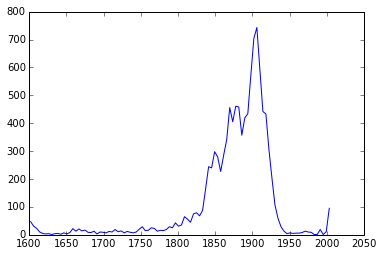

In [109]:
plt.plot(res[0], res[1])

## Construct a corpus-wide vocabulary
We could have done the above histogram without ever invoking a distributed processing framework of course by simply extracting the years from the metadata. The text body of each data element is where the bulk of the data volume lies. 

To construct a corpus wide vocabulary, we have to deconstruct each document into a list of words and then extract the unique words from the entire data set. If our dataset fit into memory of a single machine, this is a simple set operation. But what if it doesn't? 

We'll assume this is the case and instead of converting each `gid,text` pair into a `gid,list_of_words` pair, we will simply construct one RDD of words. Here we aren't necessarily interested in preserving the provenance of words, but just finding the unique words in the whole corpus. 

1. map the entire RDD of text into an RDD of single words
2. use the `distinct` method of the resulting RDD to transform it into an RDD with only unique words

In [116]:
distinct_rdd = cleaned_rdd.flatMap(lambda (gid, text): text.split()).distinct()

In [117]:
print "Number of unique words: ", distinct_rdd.count()

Number of unique words:  2805049


In [124]:
word_count = (cleaned_rdd.flatMap(lambda (gid, text): [(word,1) for word in text.split()])
                         .reduceByKey(lambda a,b: a+b)
                         .sortBy(lambda (word, count): count, False))

In [125]:
word_count.take(100)

[('the', 47035036),
 ('of', 25973952),
 ('and', 24212041),
 ('to', 20546246),
 ('a', 15731834),
 ('in', 13394565),
 ('that', 9063159),
 ('i', 8370910),
 ('he', 8367365),
 ('was', 8131835),
 ('it', 7657038),
 ('his', 6919891),
 ('with', 6272850),
 ('for', 5850743),
 ('as', 5774070),
 ('is', 5769890),
 ('you', 5413220),
 ('had', 5075729),
 ('not', 4668707),
 ('her', 4372450),
 ('at', 4368744),
 ('be', 4363714),
 ('but', 4358541),
 ('on', 4172546),
 ('by', 3914924),
 ('this', 3744877),
 ('which', 3597949),
 ('she', 3554704),
 ('have', 3436484),
 ('from', 3281687),
 ('or', 3192292),
 ('him', 3102583),
 ('they', 3084159),
 ('all', 3069227),
 ('my', 2733775),
 ('were', 2673387),
 ('are', 2478379),
 ('so', 2449712),
 ('we', 2443400),
 ('one', 2348789),
 ('me', 2296231),
 ('an', 2257107),
 ('their', 2219106),
 ('no', 2122726),
 ('if', 2117104),
 ('there', 2063181),
 ('would', 1969250),
 ('who', 1964489),
 ('when', 1900255),
 ('been', 1882207),
 ('said', 1873861),
 ('them', 1873651),
 ('will', 

Now lets exclude the most trivial words (stop words): 

In [130]:
ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fify", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

In [134]:
word_count = (cleaned_rdd.flatMap(lambda (gid, text): [(word,1) for word in text.split() if word not in ENGLISH_STOP_WORDS])
                         .reduceByKey(lambda a,b: a+b)
                         .sortBy(lambda (word, count): count, False))

## Reduces, Shuffles, and Partitioning
During a `reduceByKey`, or any other reduction for that matter, data must be shuffled around the cluster and combined. By default, this is done in an intelligent way by first reducing values locally on each partition, and then combining the results of the partitions. Still, as is the case here, for common keys, every partition will have to send its results to others. This can result in a lot of temporary file IO if the data that needs to be communicated can't all be held in memory on all of the executors. 

One way around this is to partition the data ahead of time so that the same keys land on the same partition by design. This results in much less data needing to be shipped around the network and can improve the performance. Of course, at the cost of an expensive initial shuffle! But if many reductions have to be done on the same data, it might be worth it. 

In [146]:
word_rdd = cleaned_rdd.flatMap(lambda (gid, text): [(word,1) for word in text.split() if word not in ENGLISH_STOP_WORDS]).cache()

In [147]:
word_rdd.count()

323043148

In [151]:
par = word_rdd.partitionBy(200, lambda x: hash(x)%200).cache()
par.count()

323043148

In [152]:
%%time
word_rdd.reduceByKey(lambda a,b: a+b).count()

CPU times: user 55 ms, sys: 12 ms, total: 67 ms
Wall time: 25.2 s


2804732

In [153]:
%%time
par.reduceByKey(lambda a,b: a+b).count()

CPU times: user 57 ms, sys: 5 ms, total: 62 ms
Wall time: 16.8 s


2804732